In [135]:
import requests
import zipfile
import io
import pandas as pd

In [136]:
def increment_date_by_month(date_str, increment):
    # Step 1: Convert the string to a datetime object
    date = pd.to_datetime(date_str, format='%Y%m%d')
    
    # Step 2: Add one month
    next_month_date = date + pd.DateOffset(months=increment)
    
    # Step 3: Convert the datetime object back to a string in the desired format
    return next_month_date.strftime('%Y%m%d')

In [137]:
url = 'http://mis.nyiso.com/public/'
df_year = []
year = 20200101
for i in range(12):
    url_date = increment_date_by_month(year, i)
    zip_url = f'csv/realtime/{url_date}realtime_zone_csv.zip'

    #GET request
    response = requests.get(url+zip_url)

    #check if it went through
    if response.status_code == 200:
        #extract zip file
        with zipfile.ZipFile(io.BytesIO(response.content), 'r') as zip_ref:
            file_list = zip_ref.namelist()
            #initialize an empty list

            dfs =[]

            #loop through CSV
            for file_name in file_list:
                if file_name.endswith('.csv'):
                    with zip_ref.open(file_name) as csv_file:
                        df = pd.read_csv(csv_file)
                    
                    dfs.append(df)
            
            #merge dataframes
            combined_df = pd.concat(dfs, ignore_index=True)
            df_year.append(combined_df)
    else:
        print('Failed to download ZIP files')

real_time = pd.concat(df_year, ignore_index=True)

In [138]:
df_year = []
for i in range(12):
    url_date = increment_date_by_month(year, i)
    zip_url = f'csv/damlbmp/{url_date}damlbmp_zone_csv.zip'

    #GET request
    response = requests.get(url+zip_url)

    #check if it went through
    if response.status_code == 200:
        #extract zip file
        with zipfile.ZipFile(io.BytesIO(response.content), 'r') as zip_ref:
            file_list = zip_ref.namelist()
            #initialize an empty list

            dfs =[]

            #loop through CSV
            for file_name in file_list:
                if file_name.endswith('.csv'):
                    with zip_ref.open(file_name) as csv_file:
                        df = pd.read_csv(csv_file)
                    
                    dfs.append(df)
            
            #merge dataframes
            combined_df = pd.concat(dfs, ignore_index=True)
            df_year.append(combined_df)
    else:
        print('Failed to download ZIP files')

day_ahead = pd.concat(df_year, ignore_index=True)

In [139]:
real_time = real_time[real_time['Name'] == 'LONGIL']
day_ahead = day_ahead[day_ahead['Name'] == 'LONGIL']

real_time.drop(columns=['Name', 'PTID'], inplace= True)
day_ahead.drop(columns=['Name', 'PTID'], inplace= True)

In [140]:
day_ahead['Time Stamp'] = pd.to_datetime(day_ahead['Time Stamp'])
day_ahead.set_index('Time Stamp', inplace= True)

real_time['Time Stamp'] = pd.to_datetime(real_time['Time Stamp'])
real_time.set_index('Time Stamp', inplace= True)
real_time.head()

,LBMP ($/MWHr),Marginal Cost Losses ($/MWHr),Marginal Cost Congestion ($/MWHr)
Time Stamp,,,
2020-01-01 00:05:00,17.88,-0.89,-27.39
2020-01-01 00:10:00,21.67,-0.52,-27.36
2020-01-01 00:15:00,21.74,0.37,-17.68
2020-01-01 00:20:00,20.77,0.53,-14.93
2020-01-01 00:25:00,21.27,0.51,-15.57


In [141]:
#test to ensure it is accurate
print(real_time[:11].index.mean())
real_time[:11].mean()

2020-01-01 00:30:00


LBMP ($/MWHr)                        20.758182
Marginal Cost Losses ($/MWHr)         0.009091
Marginal Cost Congestion ($/MWHr)   -20.608182
dtype: float64

In [142]:
real_time = real_time.resample('60min').mean()
real_time.head()

,LBMP ($/MWHr),Marginal Cost Losses ($/MWHr),Marginal Cost Congestion ($/MWHr)
Time Stamp,,,
2020-01-01 00:00:00,20.758182,0.009091,-20.608182
2020-01-01 01:00:00,19.516667,0.125833,-18.130833
2020-01-01 02:00:00,17.534167,0.011667,-17.410000
2020-01-01 03:00:00,16.461667,-0.096667,-17.576667
2020-01-01 04:00:00,19.843333,-0.229167,-22.470833


In [143]:
real_time.describe()

,LBMP ($/MWHr),Marginal Cost Losses ($/MWHr),Marginal Cost Congestion ($/MWHr)
count,8784.000000,8784.000000,8784.000000
mean,28.063187,1.777999,-10.846995
std,28.033050,1.337945,25.277517
min,-114.394000,-21.411667,-1345.904167
25%,15.558333,1.151458,-12.935625
50%,20.325417,1.636250,-2.083333
75%,30.849583,2.247589,0.000000
max,1378.428333,31.755000,128.649333


In [144]:
day_ahead.describe()

,LBMP ($/MWHr),Marginal Cost Losses ($/MWHr),Marginal Cost Congestion ($/MWHr)
count,8784.000000,8784.000000,8784.000000
mean,27.981364,2.047832,-10.493624
std,14.919777,0.937131,11.249814
min,9.080000,0.020000,-115.730000
25%,18.740000,1.410000,-12.960000
50%,24.250000,1.920000,-7.130000
75%,31.832500,2.560000,-3.510000
max,161.000000,7.830000,0.000000


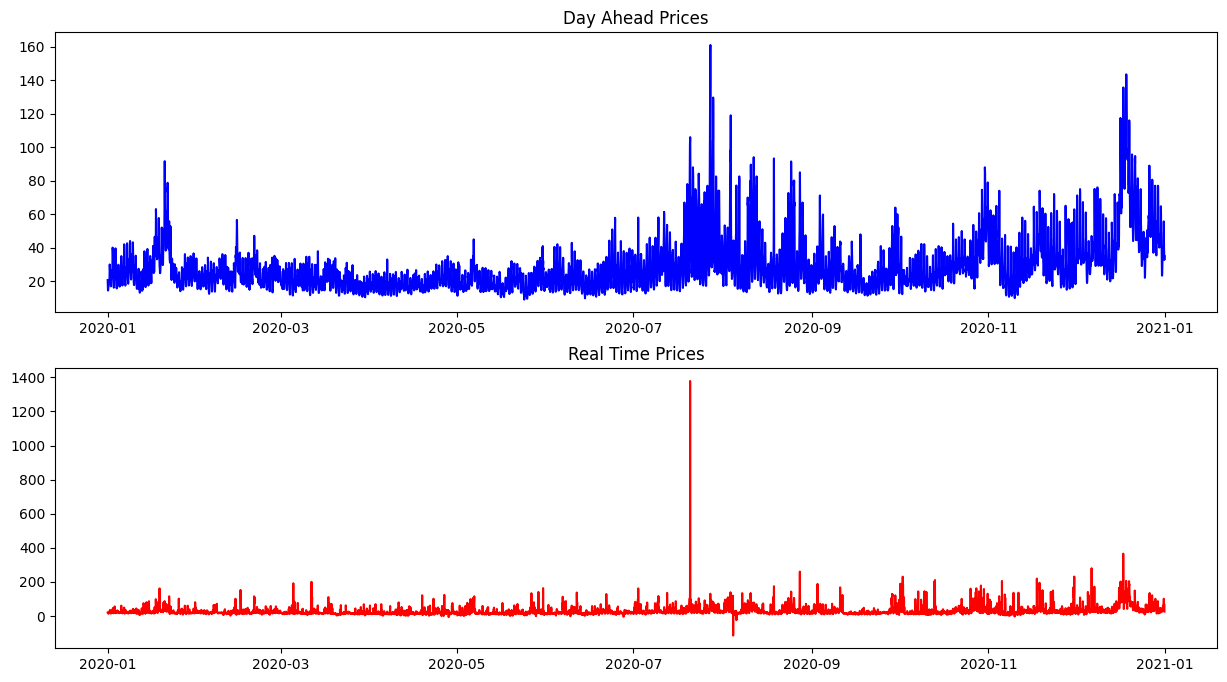

In [ ]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(15,8))

ax1.plot(day_ahead['LBMP ($/MWHr)'], color = 'blue')
ax1.set_title('Day Ahead Prices')

ax2.plot(real_time['LBMP ($/MWHr)'][:100000], color = 'red')
ax2.set_title('Real Time Prices')

plt.show()

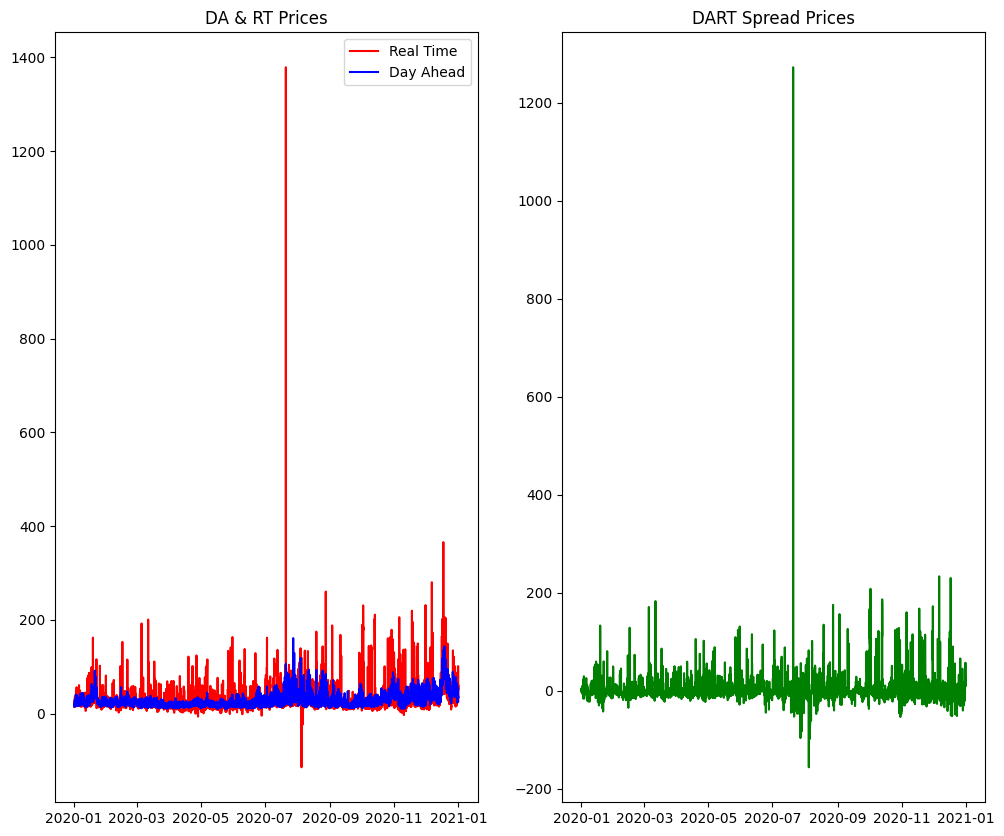

In [154]:
# Placing the plots in the plane

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 10))
ax1.plot(real_time['LBMP ($/MWHr)'], color = 'red', label= 'Real Time')
ax1.plot(day_ahead['LBMP ($/MWHr)'], color = 'blue', label= 'Day Ahead')
ax1.set_title('DA & RT Prices')
ax1.legend()

ax2.plot(real_time['LBMP ($/MWHr)'] - day_ahead['LBMP ($/MWHr)'], color = 'green', label= 'DART Spread')
ax2.set_title('DART Spread Prices')

plt.show()